Calculate the Bayes Factor for the absolute magnitude to determine whether the void and wall samples are drawn from the same or different parent distributions.

In [9]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import pickle

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import matplotlib
import matplotlib.pyplot as plt

# sys.path.insert(1,"/home/codebind/Bootes/Void_analysis/nb/Fatima_Zaidouni/")
from functions import Model_1_plot, Model_2_plot, uniform, jeffreys, Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler
#from functions_gauss import Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler

np.set_printoptions(threshold=sys.maxsize)

In [10]:
matplotlib.rc('font', size=14)
matplotlib.rc('font', family='DejaVu Sans')

# Data
## Full NSA Catalog

In [11]:
data_filename = '/home/codebind/Bootes/NSA_Full.fits'

hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

### Just keep the main SDSS DR7 footprint

In [12]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]
del data

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]
del catalog_SDSS

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]
del catalog_north

In [13]:
rabsmag_NSA = np.array(catalog_main['ELPETRO_ABSMAG'][:,4])

In [14]:
del catalog_main

## Kirshner Data

In [15]:
KNSA = Table.read('/home/codebind/Bootes/My Code/KNSA.txt', format = "ascii.commented_header")

# Fit the $M_r$ distributions with skewnormal distributions

Both one- and two-parent models

In [16]:
#rabsmag_bins = np.linspace(-25, -12.5, 170)
rabsmag_bins = np.arange(-24, -15, 0.1)
k_bins = np.arange(-24, -15, 0.4)

This is a unimodal distribution, but we are fitting it with a sum of two skew normals to account for the extra bumps in the distributions.

## 1-parent model

In [19]:
'''
rabsmag_fit_bounds1 = [[0.1, 10],     # s ...... Gaussian 1 to 2 scale factor
                       [1000, 20000], # a ...... Gaussian amplitude
                       [-22, -18],    # mu ..... Gaussian location
                       [0.1, 3],      # sigma .. Gaussian scale
                       [0, 5]]        # skew ... Gaussian skew
'''
rabsmag_fit_bounds1 = [[1e-5, 1],    # s ........ Gaussian 1 to 2 scale factor
                       [1000, 100000],  # a ........ Gaussian a amplitude
                       [-22, -18],      # mu_a ..... Gaussian a location
                       [1e-5, 2],    # sigma_a .. Gaussian a scale
                       [-5, 5]]      # skew_a ... Gaussian a skew

rabsmag_bestfit1 = Model_1_fit(rabsmag_fit_bounds1, 
                                  rabsmag_NSA, 
                                  KNSA['ABSMAG'], 
                                  rabsmag_bins, 
                                  k_bins, 
                                  1)

rabsmag_bestfit1

running minimizer...this might take a few minutes...


      fun: 9846.239313677655
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.82854967,  0.00545852,  0.61827445, -0.96333679, -1.70821296])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 786
      nit: 66
     njev: 131
   status: 0
  success: True
        x: array([ 2.38261176e-03,  5.10536473e+04, -2.14807124e+01,  1.75892140e+00,
        2.91155586e+00])

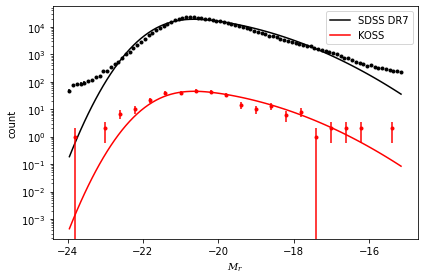

In [20]:
Model_1_plot(rabsmag_bestfit1.x, 
             rabsmag_NSA, 
             KNSA['ABSMAG'], 
             rabsmag_bins, 
             k_bins,
             1, 
             xlabel_text='$M_r$')

### Nested sampling of Likelihood and Priors

In [11]:
def prior_xform1_uni_V2(u):
    '''
    Priors for the 5 parameters of unimodel M1 for V2.  Required by 
    the dynesty sampler.  Note that this is customized for the 
    absolute magnitude fitting.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    '''
    s = uniform(0.1, 5, u[0])
    a = jeffreys(1000, 10000, u[1])
    mu = uniform(-22, -18, u[2])
    sigma = uniform(0.01, 5, u[3])
    skew = uniform(0, 5, u[4])

    return s, a, mu, sigma, skew
    '''
    s = uniform(1e-5, 1e-2, u[0])
    
    a = jeffreys(30000, 40000, u[1])
    mu_a = uniform(-22, -20, u[2])
    sigma_a = uniform(1, 2, u[3])
    skew_a = uniform(2, 3, u[4])
    
    return s, a, mu_a, sigma_a, skew_a

In [12]:
Model_1_sampler(prior_xform1_uni_V2, 
                rabsmag_NSA, 
                KNSA['ABSMAG'], 
                rabsmag_bins,
                k_bins,
                1, 
                '_rabsmag')

running the nested sampler... this might take from minutes to hours...


5508it [02:40, 34.41it/s, batch: 0 | bound: 18 | nc: 1 | ncall: 62395 | eff(%):  8.688 | loglstar:   -inf < -31733.850 <    inf | logz: -31746.843 +/-  0.113 | dlogz: 17931.567 >  0.010]  


KeyboardInterrupt: 

In [9]:
#temp_infile = open('dynesty_output/sampler_results_model1_gauss_rabsmag_V2.pickle', 'rb')
temp_infile = open('dynesty_output/sampler_results_model1_rabsmag.pickle', 'rb')
dres1_rabsmag = pickle.load(temp_infile)
temp_infile.close()

In [10]:
labels1_uni = ['s', 'a', r'$\mu$', r'$\sigma$', 'skew']
labels2_uni = ['a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']

In [11]:
labels1_bi = ['s', 'a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 
                    'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']
labels2_bi = ['$a_1$', r'$\mu_{1a}$', r'$\sigma_{1a}$', 'skew$_{1a}$', 
               '$b_1$', r'$\mu_{1b}$', r'$\sigma_{1b}$', 'skew$_{1b}$', 
               '$a_2$', r'$\mu_{2a}$', r'$\sigma_{2a}$', 'skew$_{2a}$', 
               '$b_2$', r'$\mu_{2b}$', r'$\sigma_{2b}$', 'skew$_{2b}$']

In [12]:
#n_params = len(labels1_uni)
n_params = len(labels1_bi)

fig, axes = dyplot.cornerplot(dres1_rabsmag, smooth=0.03, 
                              labels=labels1_bi, 
                              #labels=labels1_uni, 
                              show_titles=True, 
                              truths=rabsmag_bestfit1.x, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

NameError: name 'rabsmag_bestfit1' is not defined

In [13]:
lnzM1_rabsmag = dres1_rabsmag.logz[-1]
lnzM1_rabsmag

-984.9842441026252

In [14]:
rabsmag_bestfit1_dynesty,_ = dyfunc.mean_and_cov(dres1_rabsmag.samples, 
                                                    np.exp(dres1_rabsmag.logwt - lnzM1_rabsmag))

rabsmag_bestfit1_dynesty

array([ 2.39243320e-03,  3.27003589e+04, -2.13145073e+01,  1.16096111e+00,
        2.37682003e+00,  1.84617747e+04, -2.12272584e+01,  2.24290898e+00,
        1.94569114e+00])

In [15]:
Model_1_plot(rabsmag_bestfit1.x, 
             rabsmag_NSA, 
             KNSA['ABSMAG'], 
             rabsmag_bins,
             k_bins,
             1, 
             xlabel_text='$M_r$', 
             title_text='$V^2$ (minimize)')

Model_1_plot(rabsmag_bestfit1_dynesty, 
             rabsmag_NSA, 
             KNSA['ABSMAG'], 
             rabsmag_bins,
             k_bins,
             1, 
             xlabel_text='$M_r$', 
             title_text='$V^2$ (Dynesty)')

NameError: name 'rabsmag_bestfit1' is not defined

## 2-parent model

In [18]:
rabsmag_fit_bounds2 = [[10000, 100000], # a1 ........ Gaussian A amplitude
                       [-22, -21.2],    # mu_a1 ..... Gaussian A location
                       [1, 10],     # sigma_a1 .. Gaussian A scale
                       [0, 10],       # skew_a1 ... Gaussian A skew
                       [1, 200], # a2 ........ Gaussian A amplitude
                       [-23, -21],    # mu_a2 ..... Gaussian A location
                       [0.1, 5],      # sigma_a2 .. Gaussian A scale
                       [-5, 5],       # skew_a2 ... Gaussian A skew

rabsmag_bestfit2 = Model_2_fit(rabsmag_fit_bounds2, 
                                  rabsmag_NSA, 
                                  KNSA['ABSMAG'], 
                                  rabsmag_bins,
                               k_bins,
                                  1)

rabsmag_bestfit2

running minimizer...this might take a few minutes...


      fun: 1408.7420872586147
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02114405, -0.8760707 , -0.0338332 , -0.09356426,  0.02075755,
       -0.3219611 , -1.06942934, -0.29890543,  0.11423261,  0.71231619,
        0.44858553, -0.40702162,  0.0522959 , -0.9091763 , -0.3663217 ,
        0.28310294])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12495
      nit: 631
     njev: 735
   status: 0
  success: True
        x: array([ 2.52376459e+04, -2.13632022e+01,  2.13922950e+00,  8.03189588e+00,
        2.58561171e+04, -2.01725290e+01,  9.52254237e-01, -8.08260485e-01,
        1.17704395e+02, -2.14603553e+01,  1.37328985e+00,  1.43065796e+00,
        1.34229492e+02, -1.80000000e+01,  2.65491791e+01,  9.68853376e+00])

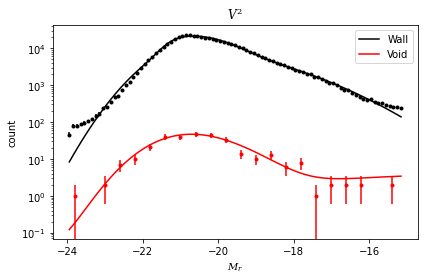

In [19]:
Model_2_plot(rabsmag_bestfit2.x, 
             rabsmag_NSA, 
             KNSA['ABSMAG'], 
             rabsmag_bins,
             k_bins,
             1, 
             xlabel_text='$M_r$', 
             title_text='$V^2$')

#### Nested sampling of Likelihood and Priors

In [ ]:
# def prior_xform2_uni_V2(u):
#     '''
#     Priors for the 8 parameters of unimodel M2.  Required by the dynesty 
#     sampler.


#     PARAMETERS
#     ==========

#     u : ndarray
#         Array of uniform random numbers between 0 and 1.


#     RETURNS
#     =======
    
#     priors : ndarray
#         Transformed random numbers giving prior ranges on model parameters.
#     '''

#     a = jeffreys(1000, 10000, u[0])
#     mu_a = uniform(-24, -18, u[1])
#     sigma_a = uniform(0.1, 5, u[2])
#     skew_a = uniform(0, 5, u[3])

#     b = jeffreys(10000, 50000, u[4])
#     mu_b = uniform(-24, -18, u[5])
#     sigma_b = uniform(0.1, 5, u[6])
#     skew_b = uniform(0, 5, u[7])

#     return a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b




In [24]:
def prior_xform2_bi_V2(u):
    '''
    Priors for the 16 parameters of bimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a1 = jeffreys(30000, 50000, u[0])
    mu_a1 = uniform(-23, -21.2, u[1])
    sigma_a1 = uniform(.01, 5, u[2])
    skew_a1 = uniform(-10, 10, u[3])
    
    a2 = jeffreys(10, 150, u[8])
    mu_a2 = uniform(-23, -21, u[9])
    sigma_a2 = uniform(0.01, 10, u[10])
    skew_a2 = uniform(-10, 10, u[11])

    return a1, mu_a1, sigma_a1, skew_a1, b1, \
           a2, mu_a2, sigma_a2, skew_a2


In [25]:
Model_2_sampler(prior_xform2_bi_V2, 
                rabsmag_NSA, 
                KNSA['ABSMAG'], 
                rabsmag_bins,
                k_bins,
                1, 
                '_rabsmag')

running the nested sampler... this might take from minutes to hours...


67179it [20:38, 54.26it/s, batch: 0 | bound: 419 | nc: 1 | ncall: 2288135 | eff(%):  2.936 | loglstar:   -inf < -951.274 <    inf | logz: -1012.818 +/-  0.231 | dlogz:  0.000 >  0.010]      


sampler output saved as pickle file 'dynesty_output/sampler_results_model2_rabsmag'


In [26]:
temp_infile = open('dynesty_output/sampler_results_model2_rabsmag.pickle', 'rb')
dres2_rabsmag = pickle.load(temp_infile)
temp_infile.close()

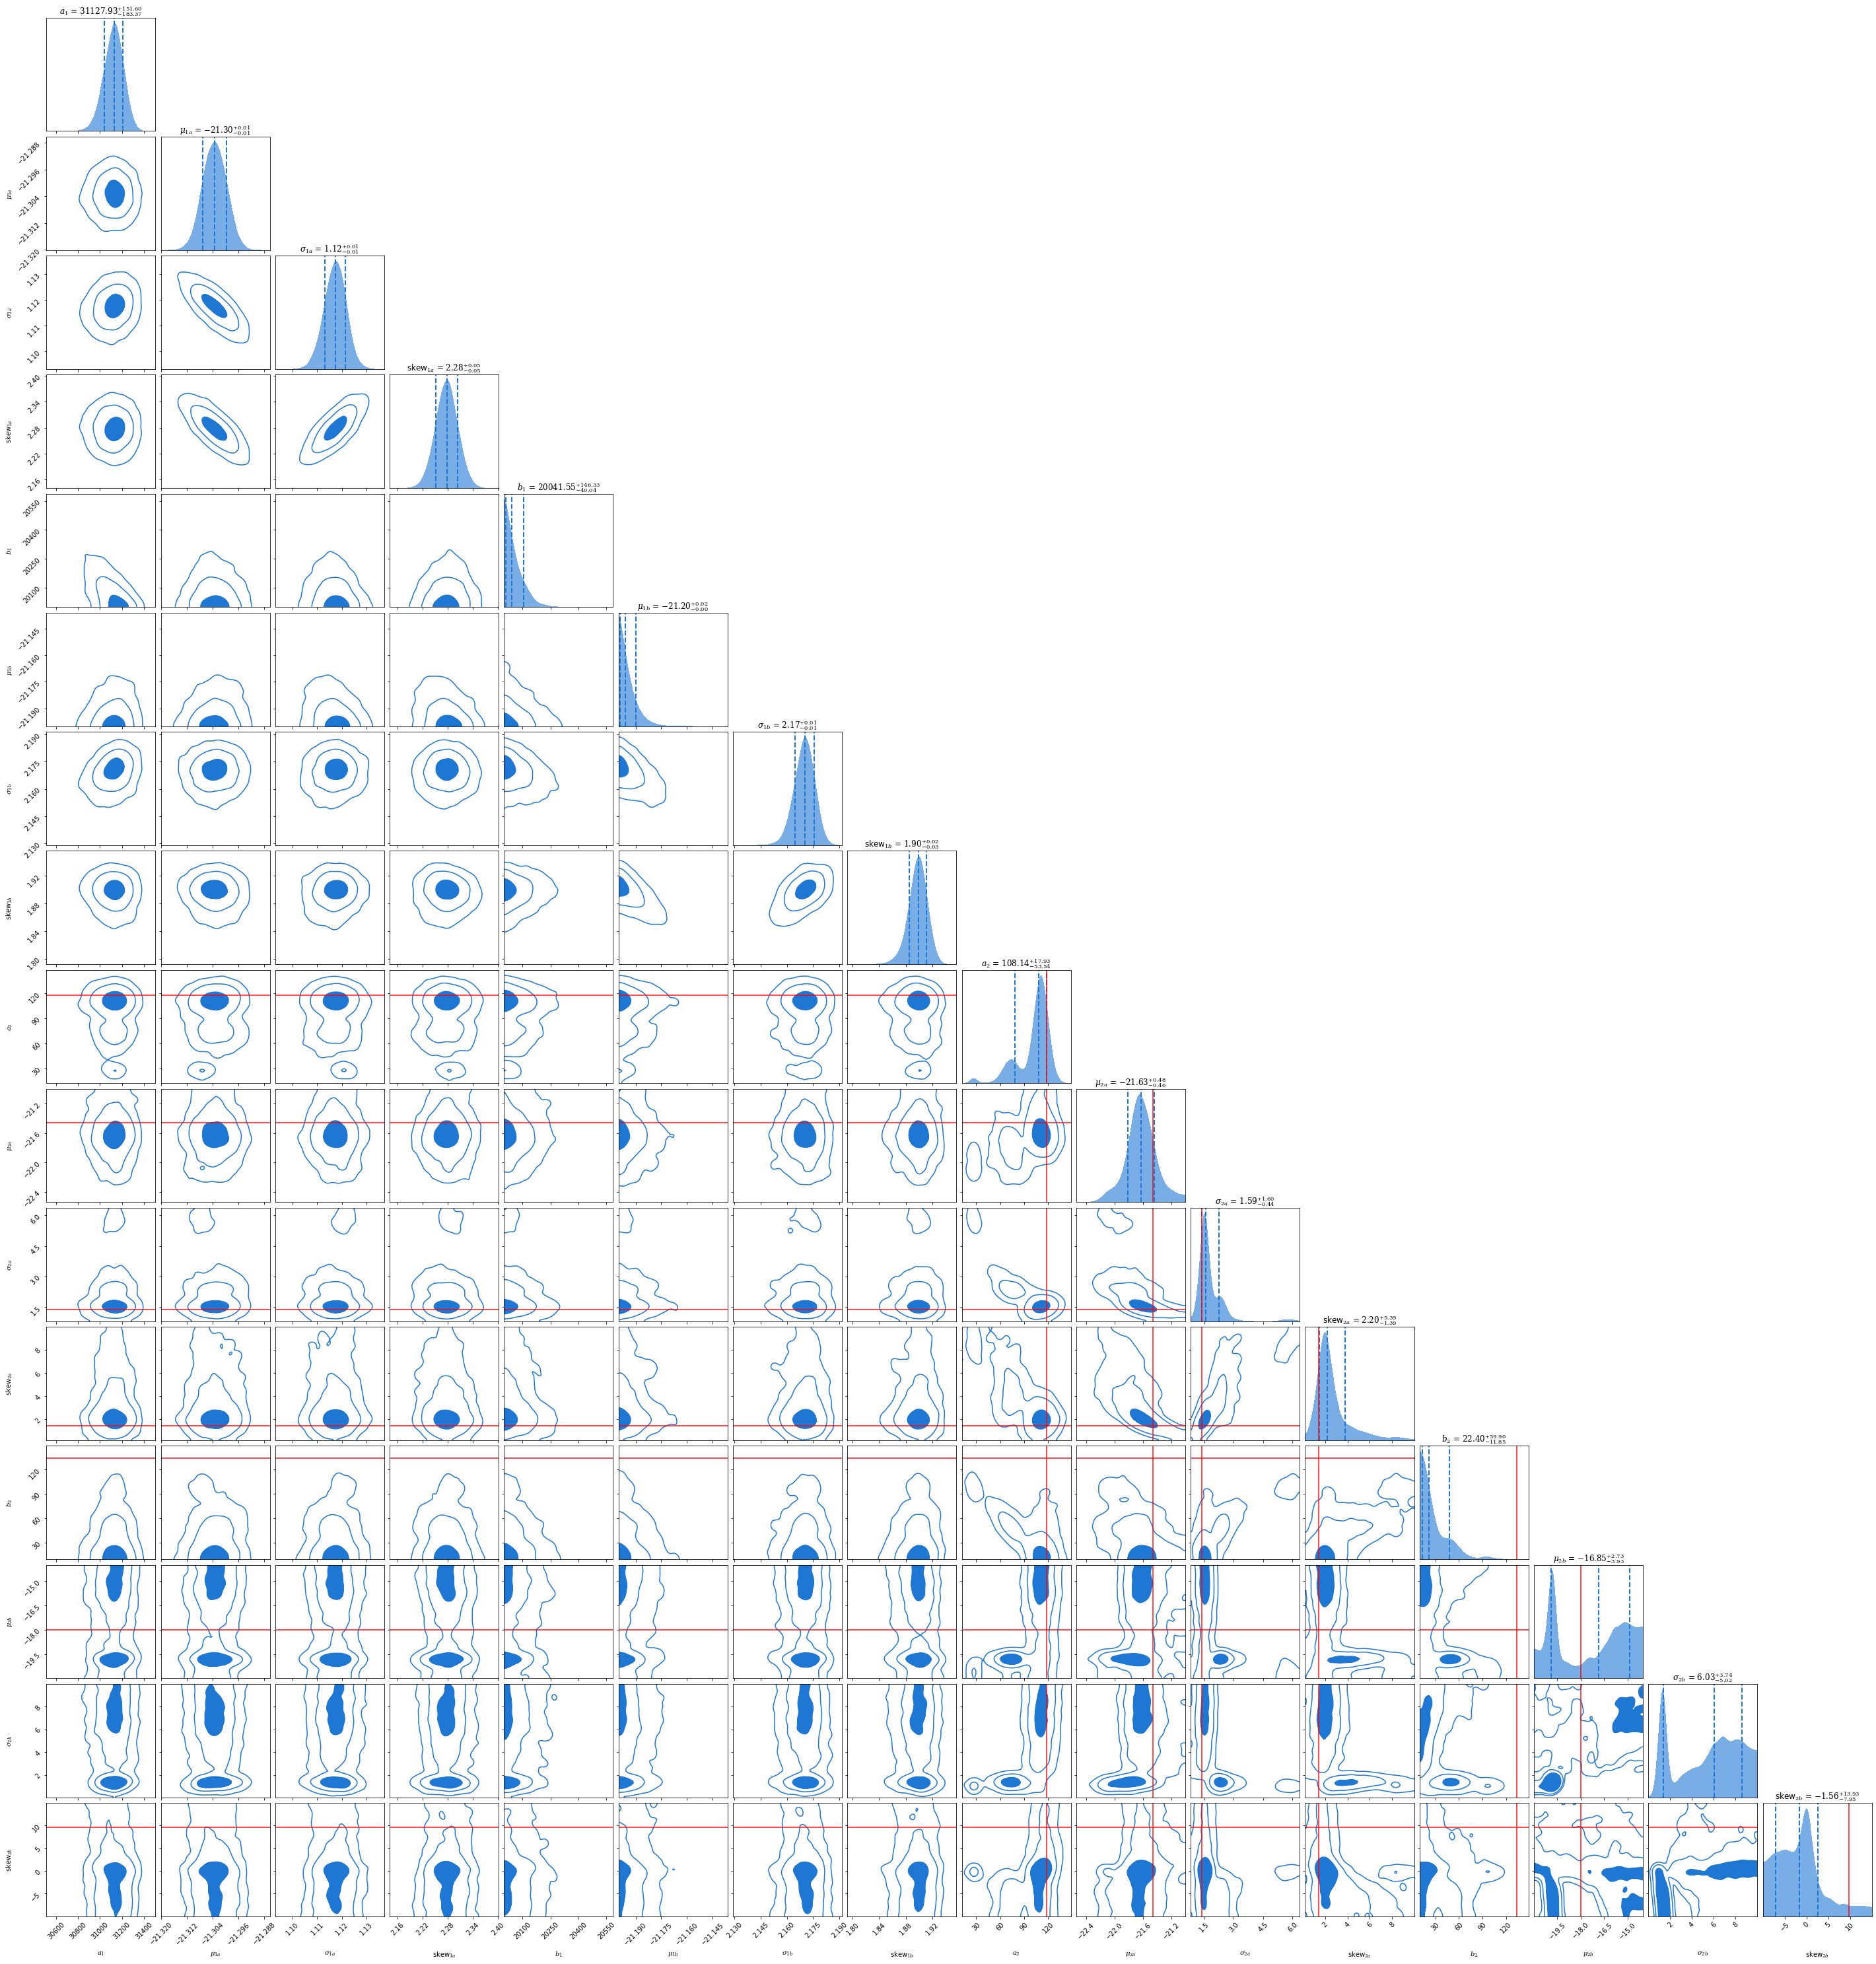

In [27]:
nparams = len(labels2_bi)

fig, axes = dyplot.cornerplot(dres2_rabsmag, smooth=0.03, 
                              labels=labels2_bi, 
                              truths=rabsmag_bestfit2.x, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(nparams, nparams, figsize=(2.5*nparams, 2.6*nparams)), 
                              color='#1f77d4')

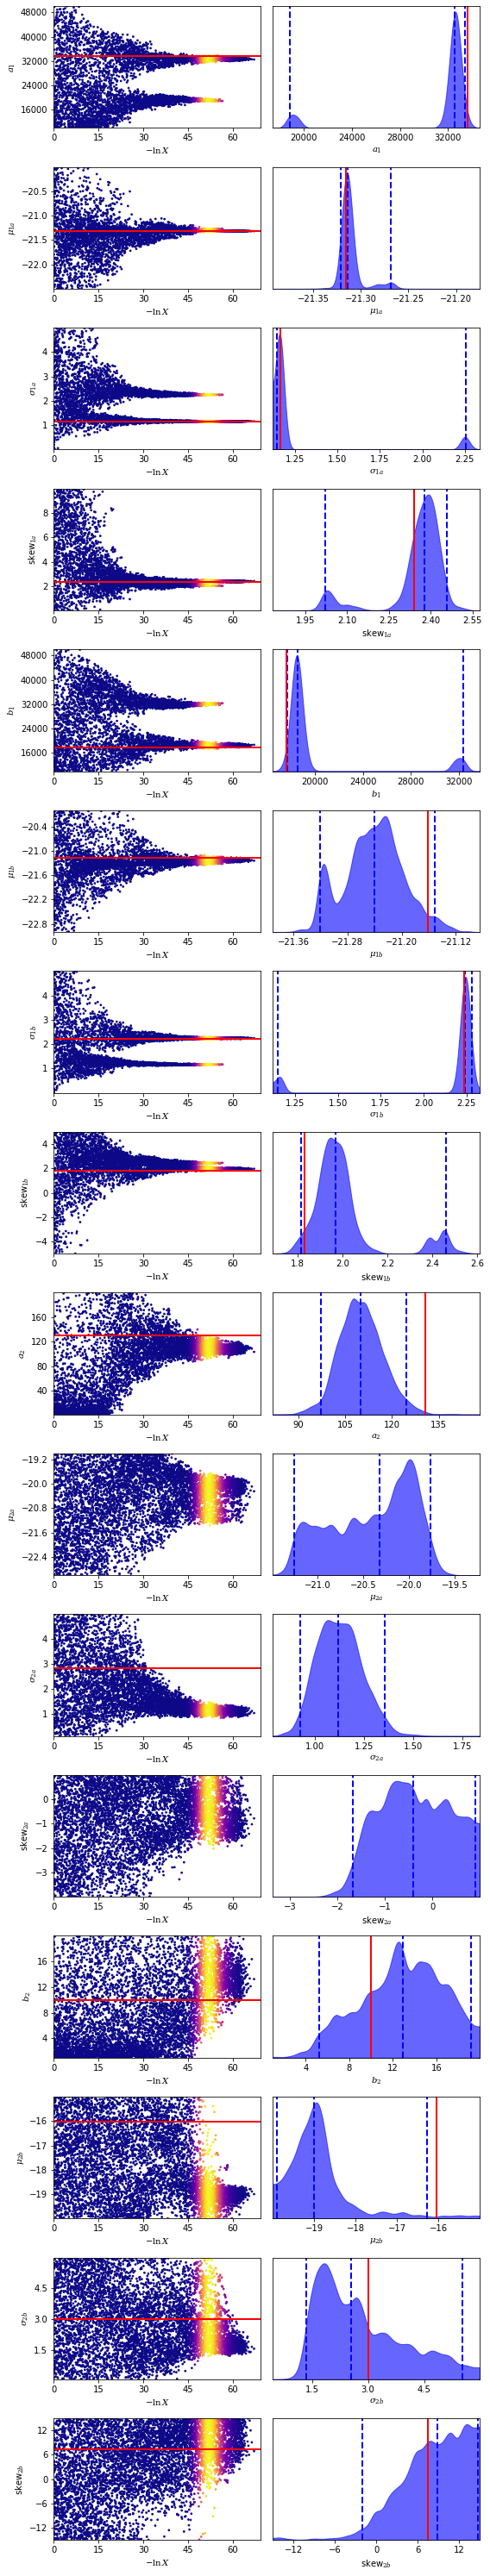

In [24]:
n_params = len(labels2_bi)

fig, axes = dyplot.traceplot(dres2_rabsmag, 
                             labels=labels2_bi, 
                             truths=rabsmag_bestfit2.x, 
                             fig=plt.subplots(n_params, 1, figsize=(8, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [25]:
lnzM2_rabsmag = dres2_rabsmag.logz[-1]
lnzM2_rabsmag

-995.19074814312

In [26]:
rabsmag_bestfit2_dynesty,_ = dyfunc.mean_and_cov(dres2_rabsmag.samples, 
                                                    np.exp(dres2_rabsmag.logwt - lnzM2_rabsmag))

rabsmag_bestfit2_dynesty

array([ 3.12024604e+04, -2.13110826e+01,  1.27680308e+00,  2.34706965e+00,
        1.99509898e+04, -2.12420190e+01,  2.12896295e+00,  2.00675479e+00,
        1.10065119e+02, -2.04147080e+01,  1.12453694e+00, -3.68848543e-01,
        1.28129885e+01, -1.88708709e+01,  2.83815292e+00,  8.19570416e+00])

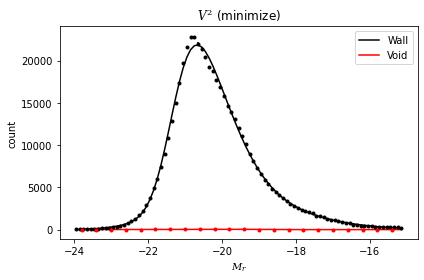

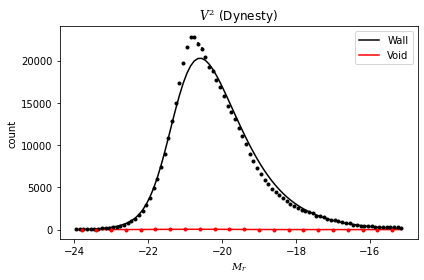

In [29]:
Model_2_plot(rabsmag_bestfit2.x, 
             rabsmag_NSA, 
             KNSA['ABSMAG'], 
             rabsmag_bins, 
             k_bins,
             1, 
             xlabel_text='$M_r$', 
             title_text='$V^2$ (minimize)')

Model_2_plot(rabsmag_bestfit2_dynesty, 
             rabsmag_NSA, 
             KNSA["ABSMAG"], 
             rabsmag_bins, 
             k_bins,
             1, 
             xlabel_text='$M_r$', 
             title_text='$V^2$ (Dynesty)')

## Bayes Factor

In [30]:
lnB12_rabsmag = lnzM1_rabsmag - lnzM2_rabsmag

B12_rabsmag = np.exp(lnB12_rabsmag)

#print('V2 Mr: B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_V2_rabsmag, np.log10(B12_V2_rabsmag)))
print('Mr: B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_rabsmag, lnB12_rabsmag*np.log10(np.exp(1))))

Mr: B12 = 2.71e+04; log(B12) = 4.433


So both $V^2$ and VoidFinder overwhelmingly favor model $\mathcal{M}_2$, in which the two data sets come from different parent distributions.